<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Stylized_Reduced_Order_L5_1_6.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Stylized-Cell-model/

/content/drive/MyDrive/Stylized-Cell-model


In [4]:
from neuron import h
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import os
from typing import Optional, List, Tuple, Union

In [5]:


from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_parameters.csv'
tstop = 1000  # ms simulation duration
dt = 0.025  # ms. does not allow change

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

In [6]:
#pick a random seed to initalize random values
import random
random.seed(427)
pi=np.pi

In [7]:
#generate lognormal distribution
m=.2
s=0.345
mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
std = np.sqrt(np.log((s/m)**2 + 1))
print(mean)
print(std)

-2.299528896659566
1.1748114608101725


Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

In [8]:
class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,biophys=None,dL=30,vrest=-65.0): #-90?
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        biophys: vector of biophysical parameters corresponding to "biophys_entries". Use -1 for default value.
        dL: maximum segment length
        vrest: reversal potential for leak channels
        """
        self.biophys = biophys
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
    
    def set_channels(self):
        """Define biophysical properties, insert channels"""
        self.define_biophys_entries()
        # common parameters
        for sec in self.all:
            sec.cm = 2.0
            sec.Ra = 100
            sec.insert('pas')
            sec.e_pas = self._vrest
        # fixed parameters
        soma = self.soma
        soma.cm = 2.0           # Originally 1 
        soma.insert('NaTa_t')  # Sodium channel
        soma.insert('SKv3_1')  # Potassium channel
        soma.insert('Ca_HVA')
        soma.insert('Ca_LVAst')
        soma.insert('CaDynamics_E2')
        soma.insert('Ih')
        soma.insert('SK_E2')
        soma.insert('K_Tst')
        soma.insert('K_Pst')
        soma.insert('Nap_Et2')
        soma.ena = 50
        soma.ek = -85
        

        for isec in self.grp_ids[1]:        # Basal, SomaApical, ProxTrunk and ProxApical dendrites
            sec = self.get_sec_by_id(isec) 
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85

        for isec in self.grp_ids[2]:
            sec = self.get_sec_by_id(isec)  # Mid Trunk
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')


        for isec in self.grp_ids[3]:
            sec = self.get_sec_by_id(isec)  # Distal Trunk
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')

        for isec in self.grp_ids[4]:
            sec = self.get_sec_by_id(isec)  # Tuft dendrites
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')


        for isec in self.grp_ids[5]:
            sec = self.get_sec_by_id(isec)  # axon 
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.insert('K_Tst')
            sec.insert('K_Pst')
            sec.insert('Nap_Et2')




        # variable parameters
        for i,entry in enumerate(self.biophys_entries):
            for sec in self.get_sec_by_id(self.grp_ids[entry[0]]):
                setattr(sec,entry[1],self.biophys[i])
        h.v_init = self._vrest
    

    def define_biophys_entries(self):
        """
        Define list of entries of biophysical parameters.
        Each entry is a pair of group id and parameter reference string.
        Define default values and set parameters in "biophys".
        """
        self.grp_sec_type_ids = [[0],[1,2,3],[4],[5],[6],[7]]  # select section id's for each group
        self.grp_ids = []  # get indices of sections for each group
        for ids in self.grp_sec_type_ids:
            secs = []
            for i in ids:
                secs.extend(self.sec_id_lookup[i])
            self.grp_ids.append(secs)
        self.biophys_entries = [
            (0,'g_pas'),(1,'g_pas'),(2,'g_pas'),(3,'g_pas'),(4,'g_pas'),(5,'g_pas'),  # g_pas of soma, basal, mid trunk, distal trunk, and tuft 
            (0,'gNaTa_tbar_NaTa_t'),(1,'gNaTa_tbar_NaTa_t'),(2,'gNaTa_tbar_NaTa_t'),(3,'gNaTa_tbar_NaTa_t'),(4,'gNaTa_tbar_NaTa_t'),(5,'gNaTa_tbar_NaTa_t'),  # gNaTa_t of soma, basal, mid trunk, distal trunk, and tuft 
            (0,'gSKv3_1bar_SKv3_1'),(1,'gSKv3_1bar_SKv3_1'),(2,'gSKv3_1bar_SKv3_1'),(3,'gSKv3_1bar_SKv3_1'),(4,'gSKv3_1bar_SKv3_1'),(5,'gSKv3_1bar_SKv3_1'),  # gSKv3_1 of soma, basal, mid trunk, distal trunk, and tuft
            (0, 'gCa_HVAbar_Ca_HVA'),(1, 'gCa_HVAbar_Ca_HVA'),(2, 'gCa_HVAbar_Ca_HVA'),(3, 'gCa_HVAbar_Ca_HVA'),(4, 'gCa_HVAbar_Ca_HVA'),(5, 'gCa_HVAbar_Ca_HVA'),  # gCA_HVA of soma, basal, distal trunk
            (0, 'gCa_LVAstbar_Ca_LVAst'),(1, 'gCa_LVAstbar_Ca_LVAst'),(2, 'gCa_LVAstbar_Ca_LVAst'),(3, 'gCa_LVAstbar_Ca_LVAst'),(4, 'gCa_LVAstbar_Ca_LVAst'),(5, 'gCa_LVAstbar_Ca_LVAst'),# gCA_LVAst of soma, basal, distal trunk
            (1, 'gImbar_Im'),(2, 'gImbar_Im'),(3, 'gImbar_Im'),(4, 'gImbar_Im'),(5, 'gImbar_Im'), # gIm of basal, mid trunk, distal trunk, and tuft
            (0,'decay_CaDynamics_E2'),(1,'decay_CaDynamics_E2'),(2,'decay_CaDynamics_E2'),(3,'decay_CaDynamics_E2'),(4,'decay_CaDynamics_E2'),(5,'decay_CaDynamics_E2'), # decay_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
            (0,'gamma_CaDynamics_E2'),(1,'gamma_CaDynamics_E2'),(2,'gamma_CaDynamics_E2'),(3,'gamma_CaDynamics_E2'),(4,'gamma_CaDynamics_E2'),(5,'gamma_CaDynamics_E2'), # gamma_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
            (0,'gIhbar_Ih'),(1,'gIhbar_Ih'),(2,'gIhbar_Ih'),(3,'gIhbar_Ih'),(4,'gIhbar_Ih'),(5,'gIhbar_Ih'), # gIh of soma, basal, midTrunk, distal trunk, and tuft
            (0,'gSK_E2bar_SK_E2'),(1,'gSK_E2bar_SK_E2'),(2,'gSK_E2bar_SK_E2'),(3,'gSK_E2bar_SK_E2'),(4,'gSK_E2bar_SK_E2'),(5,'gSK_E2bar_SK_E2'), # gSk_E2 of soma, basal, midTrunk, distal trunk, and tuft
            (0,'gK_Tstbar_K_Tst'),(5,'gK_Tstbar_K_Tst'), # gK_Tst of soma
            (0,'gK_Pstbar_K_Pst'),(5,'gK_Pstbar_K_Pst'), # gK_Pst of soma
            (0,'gNap_Et2bar_Nap_Et2'),(5,'gNap_Et2bar_Nap_Et2') # gNap_Et2 of soma
        ]

        default_biophys = np.array([0.0000338,0.0000467,0.0000589,0.0000589,0.0000589,0.0000338, ## g_pas of soma, basal, midTrunk, distal trunk, and tuft 
                                    2.04,0.0213,0.0213,0.0213,0.0213,3.89618, # gNaTa_t of soma, basal, midTrunk, distal trunk, and tuft
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.473799, # gSKv3_1 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.000992,0.000992,0.00,0.00452,0.00,0.000222,  # gCA_HVA of soma, basal, distal trunk
                                    0.00343,0.00343,0.00,0.104,0.00,0.000813, # gCA_LVAst of soma, basal, distal trunk
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.013322, # gIm of basal, mid trunk, distal trunk, and tuft 
                                    460.0,122,122,122,122,277.300774, # decay_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525, # gamma_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.0002,0.0002,0.0002,0.0002,0.0002,0.0001 , # gIh of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0812,0.077274, # gK_Tst of soma
                                    0.00223,0.188851, # gK_Pst of soma
                                    0.00172,0.005834 # gNap_Et2 of soma
                                    ])
        


        if self.biophys is not None:
            for i in range(len(self.biophys)):
                if self.biophys[i]>=0:
                    default_biophys[i]=self.biophys[i]
        self.biophys = default_biophys
    

    def add_synapse(self,stim,sec_index,**kwargs):
        """Add synapse to a section by its index"""
        self.injection.append(Synapse(self,stim,sec_index,**kwargs))
 

    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):

            return self.v_rec.as_numpy()

class Synapse(Point_current):
    def __init__(self,cell,stim,sec_index,gmaxEXC=1,gmaxINH=1,loc=0.5,record=True, SynType='exc',P_0=0.6): 
        super().__init__(cell,sec_index,loc)
        self.stim = stim
        self.gmaxEXC = gmaxEXC
        self.gmaxINH = gmaxINH
        self.syntype = SynType
        self.P_0 = P_0
        self.setup(record,loc)

        

    def setup(self,record,loc):
        self.setup_synapse(loc)
        if record:
            self.setup_recorder()
    
    def setup_synapse(self,loc): 
        if self.syntype == 'inh':
          self.pp_obj = h.int2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = self.P_0
          syn.initW = self.gmaxEXC
          self.nc = h.NetCon(self.stim,syn,1,0,1)

        else:
          self.pp_obj = h.pyr2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = self.P_0
          syn.initW = self.gmaxINH
          self.nc = h.NetCon(self.stim,syn,1,0,1)

    def setup_recorder(self):
          size = [round(h.tstop/h.dt)+1] if hasattr(h,'tstop') else []
          try:
              self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_igaba)
          except:
                  self.rec_vec = MultiSynCurrent()
                  vec_inmda = h.Vector(*size).record(self.pp_obj._ref_inmda)
                  vec_iampa = h.Vector(*size).record(self.pp_obj._ref_iampa)
                  self.rec_vec.add_vec(vec_inmda)
                  self.rec_vec.add_vec(vec_iampa)
                  

class MultiSynCurrent(object):
    def __init__(self):
        self.vec_list = []
    
    def add_vec(self,vec):
        self.vec_list.append(vec)
    
    def as_numpy(self):
        return np.sum(np.array([vec.as_numpy() for vec in self.vec_list]), axis=0)


class Simulation(object):
    def __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],
                 geo_param=[-1],biophys=[-1],
                 gmaxEXC=0.015,gmaxINH=0.015,
                 scale=1.0,ncell=1,exc_dens=2.16,
                 spike_threshold: Optional[float] = None,
                 inh_dens=0.22): #initially __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],geo_param=[-1],biophys=[-1],gmax=0.015,scale=1.0,ncell=1):
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        loc_param: location parameters, ncell-by-6 array, (x,y,z,theta,h,phi)
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        biophys: biophysical parameters, ncell-by-k array, if not specified, use default properties
        gmax: maximum conductance of synapse, ncell-vector, if is single value, is constant for all cells
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        ncell: number of cells in the simulation, required if simulating for multiple cells
        """
        self.ncell = ncell  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.set_loc_param(loc_param)
        self.set_geo_param(geo_param)
        self.set_biophys(biophys)
        self.set_gmax(gmaxEXC, gmaxINH)
        self.set_scale(scale)
        self.create_cells(exc_dens,inh_dens)  # create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time
        self.spike_threshold = None
        self.record_spikes(spike_threshold)



    def set_netstim(self, syn_number, inhfreq, excfreq, inhFRstd, excFRstd, syntype):
        """Setup synaptic input event"""
        stim_list = []
        self.stim = stim_list
        excFRlist=np.random.normal(loc=excfreq, scale=excFRstd, size=syn_number)
        inhFRlist=np.random.normal(loc=inhfreq, scale=inhFRstd, size=syn_number)
        for i in range(syn_number):
          if syntype[i] == 'inh':
            frequency = inhfreq
            spikeinterval = 1000/frequency
            stim = h.NetStim()
            stim.number = 1000 #2  # average number of spikes #check that this does not affect spike freq. hopefully only affects duration of stim. 
            #max frequency input for L5 is 16 hz meaning stim.number should be at least tstop/30, but minimize number for better runtime
            stim.start = 50 #(np.random.rand()*50)+50 #startspikes #50  #  most likely start time of first spike
            stim.noise = 1  # fractional randomness
            stim.interval =  spikeinterval #500  # mean time between spikes (ms)
            #duration of stimulation = stim.interval X stim.number
            stim_list.append(stim)
          elif syntype[i] == 'exc':
              frequency = excfreq
              spikeinterval = 1000/frequency
              stim = h.NetStim()
              stim.number = 1000 #2  # average number of spikes #check that this does not affect spike freq. hopefully only affects duration of stim. 
              #max frequency input for L5 is 16 hz meaning stim.number should be at least tstop/30, but minimize number for better runtime
              stim.start = 50 #(np.random.rand()*50)+50 #startspikes #50  #  most likely start time of first spike
              stim.noise = 1  # fractional randomness
              stim.interval =  spikeinterval #500  # mean time between spikes (ms)
              #duration of stimulation = stim.interval X stim.number
              stim_list.append(stim)


    
    def pack_parameters(self,param,ndim,param_name):
        """Pack parameters for the simulation"""
        if ndim==0:
            if not hasattr(param,'__len__'):
                param = [param]
            param = np.array(param).ravel()
            if param.size!=self.ncell:
                if param.size==1:
                    param = np.broadcast_to(param,self.ncell)
                else:
                    raise ValueError(param_name+" size does not match ncell")   
        if ndim==1:
            param = np.array(param)
            if param.ndim==1:
                param = np.expand_dims(param,0)
            if param.shape[0]!=self.ncell:
                if param.shape[0]==1:
                    param = np.broadcast_to(param,(self.ncell,param.shape[1]))
                else:
                    raise ValueError(param_name+" number of rows does not match ncell")
        return param
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-6 array"""
        loc_param = self.pack_parameters(loc_param,1,"loc_param")
        self.loc_param = [(loc_param[i,:3],loc_param[i,3:]) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.geo_param = self.pack_parameters(geo_param,1,"geo_param")
    
    def set_biophys(self,biophys):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.biophys = self.pack_parameters(biophys,1,"biophys")
    
    def set_gmax(self,gmaxEXC,gmaxINH):
        """Setup maximum conductance of synapse"""
        self.gmaxEXC = self.pack_parameters(gmaxEXC,0,"gmaxEXC")
        self.gmaxINH = self.pack_parameters(gmaxINH,0,"gmaxINH")
    
    def set_scale(self,scale):
        """setup scaling factors of lfp magnitude"""
        self.scale = self.pack_parameters(scale,0,"scale")
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            (0,'R'),  # change soma radius
            (3,'L'),  # change trunk length
            (3,'R'),  # change trunk radius
            ([1,2],'R'),  # change basal dendrites radius
            (4,'R'),  # change tuft radius
            ([1,2],'L'), # change basal,apical dendrites length
            (4,'L'), #change tuft dendrites length
            (4,'ang') # change tuft angle
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom

    def record_spikes(self, threshold: Optional[float]) -> None:
        """Setup spike recorder for all cells"""
        for cell in self.cells:
            cell.set_spike_recorder(threshold)
        self.spike_threshold = threshold

    def create_cells(self,exc_dens,inh_dens):
        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        # Create cell with morphology and biophysical parameters
        for i in range(self.ncell):
            geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
            self.cells.append( Cell(geometry=geometry,biophys=self.biophys[i,:]) )
        # add injection current or synaptic current and set up lfp recording
        min_dist = 10.0 # minimum distance allowed between segment and electrode. Set to None if not using.
        
        





        for i,cell in enumerate(self.cells):
          self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
          # Current injection in soma
          #cell.add_injection(sec_index=0,record=True,delay=150,dur=150,amp=0.1) # Tune for proper action potential 



          # still making adjustments to this one but an idea
          # extra synapses to one tuft
          # L=100
          # syn_exc_number = np.round(5*L) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
          # syn_number = int(syn_exc_number) #total number of synapses
          # print(syn_number)
          # syn_dist = (np.random.rand(syn_number) * 0.3) + 0.65 #generate distribution for location
          # rand_syntype = np.random.rand(syn_number)  #generate distribution for type
          # gmax_dist = np.random.lognormal(mean, std, syn_number) #generate distribution for gmax
          #       self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype='exc')
          #       P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
          #       for j in range(syn_number):
          #         cell.add_synapse(stim=self.stim,sec_index=sec_index_list[isec],gmaxEXC=gmax_dist[j],gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType='exc',P_0=P_0exclist[j])




          for id,sec in self.geometry.iterrows():
            sec_index_list=cell.sec_id_lookup[id]
            L = sec['L']
            #insert parameters
            excP_0mean=sec['excP_0mean']
            excP_0std=sec['excP_0std']
            inhP_0mean=sec['inhP_0mean']
            inhP_0std=sec['inhP_0std']
            excFRmean=sec['excFRmean']
            excFRstd=sec['excFRstd']
            inhFRmean=sec['inhFRmean']
            inhFRstd=sec['inhFRstd']

            #print(sec_index_list)

            if id==0: # soma
              #print('soma skipped') #skip soma
              ### add equivalent of 150 inh synapses to soma
              syn_number = 406
              #print(self.stim)
              syn_dist = np.random.rand(syn_number) #generate distribution for location
              syn_type_list = ['inh' for y in range(syn_number)] #assign randomly, adhere to proportion
              print(syn_type_list)
              self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list)
              # print(self.stim)
              P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
              for j in range(syn_number):
                cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[0],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])

            elif id==1 or id == 2 or id == 3: # basal,  proxtrunk, oblique
            #   print('basal, proxtrunk') #skip basal

            #   # add synapses to basal
              syn_exc_number = np.round((exc_dens/4)*L) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
              syn_inh_number = np.round((inh_dens/2)*L)
              syn_number = int(syn_inh_number + syn_exc_number) #total number of synapses
              # print(syn_number)
              prop_exc = syn_exc_number/syn_number #used for assigning type
              for isec in range(len(sec_index_list)):
                syn_dist = np.random.rand(syn_number) #generate distribution for location
                rand_syntype = np.random.rand(syn_number)  #generate distribution for type
                gmax_dist = np.random.lognormal(mean, std, syn_number) #generate distribution for gmax
                syn_type_list = ['exc' if y< prop_exc else #assign randomly, adhere to proportion 
                                'inh' for y in rand_syntype]
                self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list)
                # print(self.stim)
                P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
                P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
                for j in range(syn_number):
                  if  syn_type_list[j] == 'exc':
                     cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmaxEXC=gmax_dist[j],gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0exclist[j])
                  elif syn_type_list[j] == 'inh':
                    cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmaxEXC=gmax_dist[j],gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])

            #elif id==3: # oblique
              #print('oblique skipped') #skip proximal apical dendrites

            elif id==4: # midtrunk       
              #print('midtrunk skipped') #skip midsection of trunk
              #add inhibitory synapses to midtrunk
              syn_number = int(np.round(inh_dens*L)) #total number of synapses
              for isec in range(len(sec_index_list)):
                syn_dist = np.random.rand(syn_number) #generate distribution for location
                syn_type_list = ['inh' for y in range(syn_number)] #assign randomly, adhere to proportion 
                self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list)
                # print(self.stim)
                P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
                for j in range(syn_number):
                  cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])



            elif id==5: # disttrunk     
              print('disttrunk skipped') #skip distal section of trunk

            elif id==7: # axon
               print('axon skipped') #skip axon
              
            else: # add synapses to each section
              syn_exc_number = np.round(exc_dens*L*1.5) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
              syn_inh_number = np.round(inh_dens*L)
              syn_number = int(syn_inh_number + syn_exc_number) #total number of synapses
              prop_exc = syn_exc_number/syn_number #used for assigning type
              for isec in range(len(sec_index_list)):
                syn_dist = np.random.rand(syn_number) #generate distribution for location
                rand_syntype = np.random.rand(syn_number)  #generate distribution for type
                gmax_dist = np.random.lognormal(mean, std, syn_number) #generate distribution for gmax
                syn_type_list = ['exc' if y< prop_exc else #assign randomly, adhere to proportion 
                                'inh' for y in rand_syntype]
                self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list)
                # print(self.stim)
                P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
                P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
                for j in range(syn_number):
                  if  syn_type_list[j] == 'exc':
                     cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmaxEXC=gmax_dist[j],gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0exclist[j])
                  elif syn_type_list[j] == 'inh':
                    cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmaxEXC=gmax_dist[j],gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])
        

        

    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index (indices), (cells-by-)channels-by-time"""
        if not hasattr(index,'__len__'):
            lfp = self.lfp[index].calc_ecp()
        else:
            index = np.asarray(index).ravel()
            lfp = np.stack([self.lfp[i].calc_ecp() for i in index],axis=0)
        return lfp

    def get_spike_time(self, index: Union[np.ndarray, List[int], int, str] = 0) -> np.ndarray:
        """
        Return soma spike time of the cell by index (indices), ndarray (list of ndarray)
        Parameters
        index: index of the cell to retrieve the spikes from
        """
        if self.spike_threshold is None:
            raise ValueError("Spike recorder was not set up.")
        if type(index) is str and index == 'all':
            index = range(self.ncell)
        if not hasattr(index, '__len__'):
            spk = self.cells[index].spikes.as_numpy().copy()
        else:
            index = np.asarray(index).ravel()
            spk = np.array([self.cells[i].spikes.as_numpy().copy() for i in index], dtype=object)
        return spk

    def get_spike_number(self, index: Union[np.ndarray, List[int], int, str] = 0) -> Union[int, np.ndarray]:
        """
        Return soma spike number of the cell by index (indices), int (ndarray)
        Parameters
        index: index of the cell to retrieve the spikes from
        """
        if self.spike_threshold is None:
            raise ValueError("Spike recorder was not set up.")
        if index == 'all':
            index = range(self.ncell)
        if not hasattr(index, '__len__'):
            spk = self.get_spike_time(index)
            nspk = spk.size
        else:
            index = np.asarray(index).ravel()
            spk = self.get_spike_time(index)
            nspk = np.array([s.size for s in spk])
        return nspk, 

#### Create simulation

In [9]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [10]:
loc_param = [50,0,10,0,1,0]  # example position #D: initially this was [0,0,50,0.2,0.75,1.5], (x,y,z,theta,h,phi), h=[-1,1] phi=[-pi,pi] h=.7071067812 for 90 deg
#note on parameters: Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate arccos(h) about x-axis (elevation), then rotate phi about y axis (azimuth).

#geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
geo_param = [ # geo_entries need to be fixed
            -1,  # change soma radius
            -1,  # change trunk length
            -1,  # change trunk radius
            -1,  # change basal dendrites radius
            -1,  # change tuft radius
            -1, # change basal, apical dendrites length
            -1, # change tuft dendrites length
            -1 # change tuft angle # 1.309
        ]
      
      
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
biophys = [0.0000338,0.0000467,0.0000589,0.0000589,0.0000589,0.0000338, ## g_pas of soma, basal, midTrunk, distal trunk, and tuft 
                                    2.04,0.0213,0.0213,0.0213,0.0213,3.89618, # gNaTa_t of soma, basal, midTrunk, distal trunk, and tuft
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.473799, # gSKv3_1 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.000992,0.000992,0.00,0.00452,0.00,0.000222,  # gCA_HVA of soma, basal, distal trunk
                                    0.00343,0.00343,0.00,0.104,0.00,0.000813, # gCA_LVAst of soma, basal, distal trunk
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.013322, # gIm of basal, mid trunk, distal trunk, and tuft 
                                    460.0,122,122,122,122,277.300774, # decay_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525, # gamma_CaDynamics of soma, basal, mid trunk, distal trunk, and tuft
                                    0.0002,0.0002,0.0002,0.0002,0.0002,0.0001 , # gIh of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distal trunk, and tuft
                                    0.0812,0.077274, # gK_Tst of soma
                                    0.00223,0.188851, # gK_Pst of soma
                                    0.00172,0.005834 # gNap_Et2 of soma
                                    ]
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmaxEXC=0.1,gmaxINH=0.05,scale=100.,exc_dens=2.16,inh_dens=0.22,spike_threshold = 10)  # 0.001 -0.012 #gmax=.005, scale=100

['inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh', 'inh'

In [11]:
SecD_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  R = sec['R']*2
  if sec['axial']:
    SecD_list.append(R)
  else:
    SecD_list.append(R)
    SecD_list.append(R)
    SecD_list.append(R)
    SecD_list.append(R)
#print(SecD_list)

SecL_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  L = sec['L']
  if sec['axial']:
    SecL_list.append(L)
  else:
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
#print(SecL_list)

In [12]:
print('The number of synapses in the detailed model is 29028')
print('The number of synapses in the reduced-order model is',len(sim.cells[0].injection))
syn_reduce = (len(sim.cells[0].injection)/29028)
print('The number of synapses has been reduced by a factor of',(syn_reduce))
print('The number of segments in the detailed model is 13962')
print('The number of segments in the reduced-order model is',len(sim.cells[0].segments))
seg_reduce = (len(sim.cells[0].segments)/13962)
print('The number of segments has been reduced by a factor of',(seg_reduce))

# Ben's detailed L5
# Excitatory: 16070 on apical dendrites (2.16 syns/um * 7440 um)
# 10042 (2.16 syns/um * 4649 um) on basal dendrites. 
# Inhibitory: 150 on soma  (Egger et al., 2020; Markram et al., 2015; Reimann et al., 2015) + (0.22 syns/um *483 um) = 256 perisomatic, 
# 1637 (0.22 syns/um * 7440 um)  on apical dendrites, 
# 1023 (0.22 syns/um * 4649 um) on basal dendrites.

# total is 29028

#note: 
#in order to keep the same synapse ratio and synapse densities we need to have the same total length ratio
# Ben's apical to basal total length ratio thus is 1.6003 (7440um/4649um)
# our's is 1.2 (4*500um+length of trunk with synapses/12*200um)

The number of synapses in the detailed model is 29028
The number of synapses in the reduced-order model is 8562
The number of synapses has been reduced by a factor of 0.29495659363373294
The number of segments in the detailed model is 13962
The number of segments in the reduced-order model is 156
The number of segments has been reduced by a factor of 0.0111731843575419


Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [13]:
nseg = len(sim.cells[0].segments)
numTstep = int(tstop/dt)

seg_list = sim.cells[0].get_seg_by_id(range(nseg))
print(seg_list)

Vrecord = []
for i in range(0,len(seg_list)):
     Vrecord.append(seg_list[i])

dend_v = Recorder(Vrecord)

[soma(0.5), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), proxtrunk(0.0714286), proxtrunk(0.214286), proxtrunk(0.357143), proxtrunk(0.5), proxtrunk(0.642857), proxtrunk(0.785714), proxtrunk(0.928571), oblique(0.0714286), oblique(0.214286), oblique(0.357143), oblique(0.5), oblique(0.642857), oblique(0.785714), oblique(0.928571), oblique(0.0714286), oblique(0.214286), oblique(0.357143), oblique(0.5), oblique(0.642857), oblique(0.785714), oblique(0.928571), oblique(0.0714286), oblique(0.214286), oblique(0.357143), oblique(0.5), oblique(0.642857), oblique(0.785714), oblique(0.928571)

In [14]:
def returnSegmentValues(section, secnum):
    ##
    
    #Set impedance measurement location and frequency
   
    zz = h.Impedance()
    zz.loc(sim.cells[0].get_sec_by_id([0])[0](0.5))
    zz.compute(25)

    # Get section 3d coordinates and put in numpy array
    n3d = section.n3d()
    x3d = np.empty(n3d)
    y3d = np.empty(n3d)
    z3d = np.empty(n3d)
    L = np.empty(n3d)
    for i in range(n3d):
        x3d[i]=section.x3d(i)
        y3d[i]=section.y3d(i)
        z3d[i]=section.z3d(i)

    # Compute length of each 3d segment
    for i in range(n3d):
        if i==0:
            L[i]=0
        else:
            L[i]=np.sqrt((x3d[i]-x3d[i-1])**2 + (y3d[i]-y3d[i-1])**2 + (z3d[i]-z3d[i-1])**2)

    # Get cumulative length of 3d segments
    cumLength = np.cumsum(L)
    N = section.nseg
    
    # Now upsample coordinates to segment locations
    xCoord = np.empty(N)
    yCoord = np.empty(N)
    zCoord = np.empty(N)
    Elec_distance = np.empty(N)
    SecNum = np.empty(N)

    dx = section.L / (N-1)
    for n in range(N):
        Elec_distance[n] = zz.ratio(section((n*dx)/cumLength[1]))
        SecNum[n] = secnum
        if n==N-1: 
            xCoord[n]=x3d[-1]
            yCoord[n]=y3d[-1]
            zCoord[n]=z3d[-1]
        else:
            cIdxStart = np.where(n*dx >= cumLength)[0][-1] # which idx of 3d segments are we starting at
            cDistFrom3dStart = n*dx - cumLength[cIdxStart] # how far along that segment is this upsampled coordinate
            cFraction3dLength = cDistFrom3dStart / L[cIdxStart+1] # what's the fractional distance along this 3d segment
            # compute x and y positions
            xCoord[n] = x3d[cIdxStart] + cFraction3dLength*(x3d[cIdxStart+1] - x3d[cIdxStart])
            yCoord[n] = y3d[cIdxStart] + cFraction3dLength*(y3d[cIdxStart+1] - y3d[cIdxStart])
            zCoord[n] = z3d[cIdxStart] + cFraction3dLength*(z3d[cIdxStart+1] - z3d[cIdxStart])
            
    return SecNum, xCoord, yCoord, zCoord, Elec_distance

In [15]:
sec_list = sim.cells[0].get_sec_by_id(range(len(sim.cells[0].all)))

section = []
SectionXCoord = []
SectionYCoord = []
SectionZCoord = []
SectionElecDist = []
AllSegSection = []
AllSegXCoord = []
AllSegYCoord = []
AllSegZCoord = []
AllSegElecDist = []
for i in range(1,len(sec_list)):
  section, SectionXCoord, SectionYCoord, SectionZCoord, SectionElecDist = returnSegmentValues(sec_list[i], i)
  AllSegSection.extend(section)
  AllSegXCoord.extend(SectionXCoord)
  AllSegYCoord.extend(SectionYCoord)
  AllSegZCoord.extend(SectionZCoord)
  AllSegElecDist.extend(SectionElecDist)

In [16]:
gNaTa_T = Recorder(obj_list = sim.cells[0].segments, var_name = 'gNaTa_t_NaTa_t')

In [17]:
ical = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_LVAst')
icah = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_HVA')

In [18]:
ih = Recorder(obj_list = sim.cells[0].segments, var_name = 'ihcn_Ih')


In [19]:
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

In [20]:
numSyn = len(sim.cells[0].injection)

excSynPerSeg = [0]*nseg
inhSynPerSeg = [0]*nseg

i_NMDA_bySeg= [[0] * (numTstep+1) ] * nseg

print(len(sim.cells[0].injection))

for j in range(numSyn):
  seg = sim.cells[0].injection[j].get_segment_id()
  if(sim.cells[0].injection[j].syntype == 'exc'):
    excSynPerSeg[seg] += 1
  else:
    inhSynPerSeg[seg] += 1

  try:
    i_NMDA = np.array(sim.cells[0].injection[j].rec_vec.vec_list[1])            #current = numpy array of NEURON Vector of current NMDA current at synapse j  
    seg = sim.cells[0].injection[j].get_segment_id()                            #seg = the segment in which synapse j is located 
    #print('first try')
    
    try:
      i_NMDA_bySeg[seg] = i_NMDA_bySeg[seg] + i_NMDA    
      #print('second try')                                           #Sum current over each segment
    except: 
      x = j                                                                     #Except needed as some synpases do not have NMDA currrent and throw an error when called
  except:
    x = j

8562


In [21]:
ih_data = ih.as_numpy()
gNaTa_T_data = gNaTa_T.as_numpy()
icah_data = icah.as_numpy()
ical_data = ical.as_numpy()

In [22]:
spikes = sim.get_spike_time()
print(len(spikes))

8


# File Output

In [23]:
import h5py

try:
  os.remove("Segments.hdf5")
except:
  x = 1

f0 = h5py.File("Segments.hdf5", "w")

segs = f0.create_dataset("Segs", data= list(range(nseg-1)))
X = f0.create_dataset("X", data = AllSegXCoord)
Y = f0.create_dataset("Y", data = AllSegYCoord)
sec = f0.create_dataset("sec", data = AllSegSection)
neSyn = f0.create_dataset("neSyn", data= excSynPerSeg)
niSyn = f0.create_dataset("niSyn", data= inhSynPerSeg)
elec_dist = f0.create_dataset("elec_dist", data = AllSegElecDist)

f0.close()

In [24]:
try:
  os.remove("Spikes.hdf5")
except:
  x = 1

f01 = h5py.File("Spikes.hdf5", "w")

spikes = f01.create_dataset("spikes", data= spikes)

f01.close()

In [25]:
v_dend = dend_v.as_numpy()
# Voltage output

try:
  os.remove("v_report.hdf5")
except:
  x = 1

f1 = h5py.File("v_report.hdf5", "w")

voltage = f1.create_dataset("v", data= v_dend)
time = f1.create_dataset("t", data = t)

f1.close()

In [26]:
#NMDA output

try:
  os.remove("i_nmda_report.hdf5")
except:
  x = 1
  
f2 = h5py.File("i_nmda_report.hdf5", "w")

i_NMDA = f2.create_dataset("i_nmda", data = i_NMDA_bySeg)

f2.close()


In [27]:
#gNaTa output

try:
  os.remove("gNaTa_report.hdf5")
except:
  x = 1
  
f6 = h5py.File("gNaTa_report.hdf5", "w")

gNaTa = f6.create_dataset("gNaTa", data = gNaTa_T_data ) # dtype= np.float

f6.close()

In [28]:
#Calcium output
try:
  os.remove("i_CaHva_report.hdf5")
  os.remove("i_CaLva_report.hdf5")
except:
  x = 1
  
f3 = h5py.File("i_CaHva_report.hdf5", "w")
f4 = h5py.File("i_CaLva_report.hdf5", "w")

i_CaHva = f3.create_dataset("i_CaHva", data = icah_data)
i_CaLva = f4.create_dataset("i_CaLva", data = ical_data)

f3.close()
f4.close()

In [29]:
#Ih output
try:
  os.remove("ihcn_report.dhf5")
except:
  x = 1
  
f5 = h5py.File("ihcn_report.hdf5", "w")

ihcn = f5.create_dataset("ihcn", data = ih_data)

f5.close()

# Plots

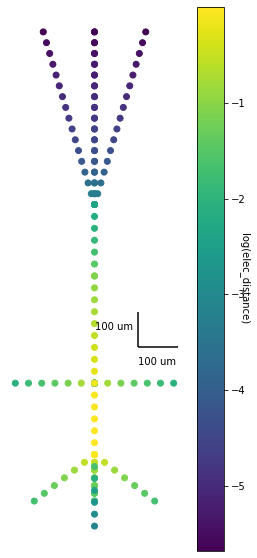

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord, c = np.log(AllSegElecDist) )
plt.vlines(110,300,400)
plt.text(0,350,'100 um')
plt.hlines(300,110,210)
plt.text(110,250,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

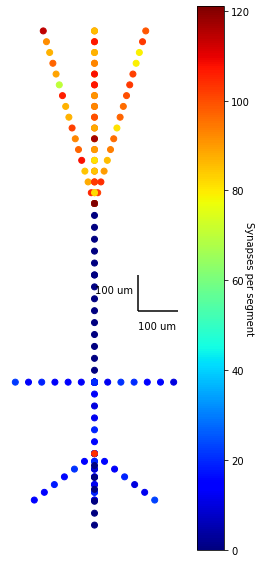

In [31]:
plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord,c = excSynPerSeg[0:(nseg-1)],cmap='jet',)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Synapses per segment', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

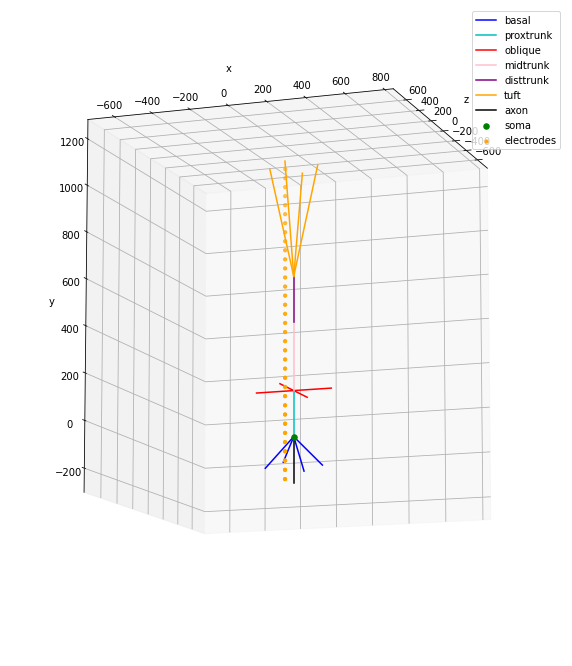

(<Figure size 720x864 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fe753663b50>)

In [32]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.plot_morphology import plot_morphology 
plot_morphology(sim,electrodes=elec_pos,elev=-10, azim=20, figsize=(10,12), clr = ['g', 'b', 'c', 'red', 'pink', 'purple','orange','black','yellow'])

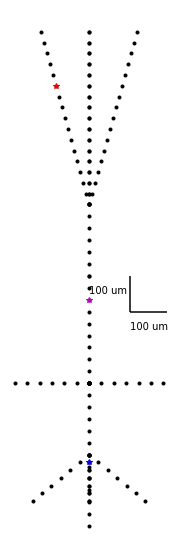

In [33]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(AllSegXCoord[125], 
         AllSegYCoord[125],
         'r*')
plt.plot(AllSegXCoord[22], 
         AllSegYCoord[22],
         'b*')
plt.plot(AllSegXCoord[70], 
         AllSegYCoord[70],
          'm*')
# plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
#          segs.loc[segs.segmentID==1500,'Coord Y'],
#          'g*')
# plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
#          segs.loc[segs.segmentID==680,'Coord Y'],
#          '*',color='orange')
# plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
#          segs.loc[segs.segmentID==482,'Coord Y'],
#          '*',color='grey')
# plt.savefig('fig1A.svg')

([], <a list of 0 Text major ticklabel objects>)

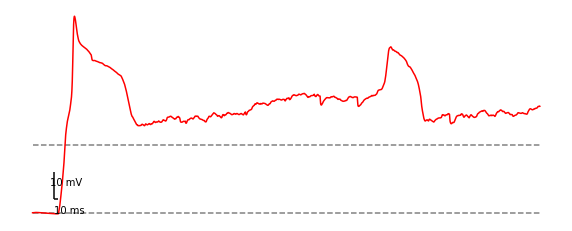

In [34]:


plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop*4)+.1),.1),v_dend[135],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.hlines(-65,0,4000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

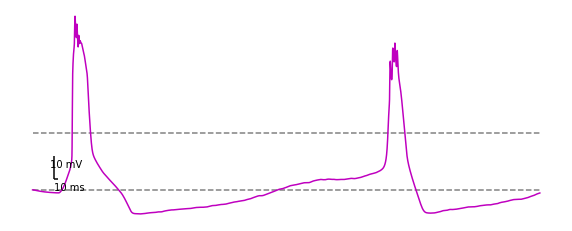

In [35]:
v_dend = dend_v.as_numpy()

plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop*4)+.1),.1),v_dend[70],color='m')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.hlines(-65,0,4000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

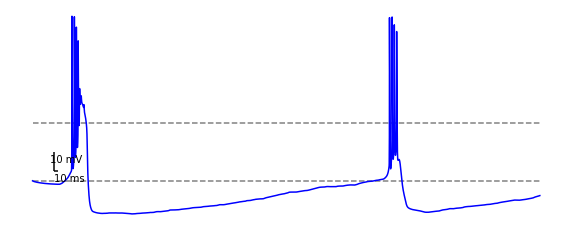

In [36]:
v_dend = dend_v.as_numpy()

plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop*4)+.1),.1),v_dend[22],color='b')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.hlines(-65,0,4000, color = 'grey', linestyle = 'dashed')
plt.hlines(-35,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

The value after the section indicates the poroportional distance along the segment. 1 being distal from the soma and 0 being proximal to the soma.

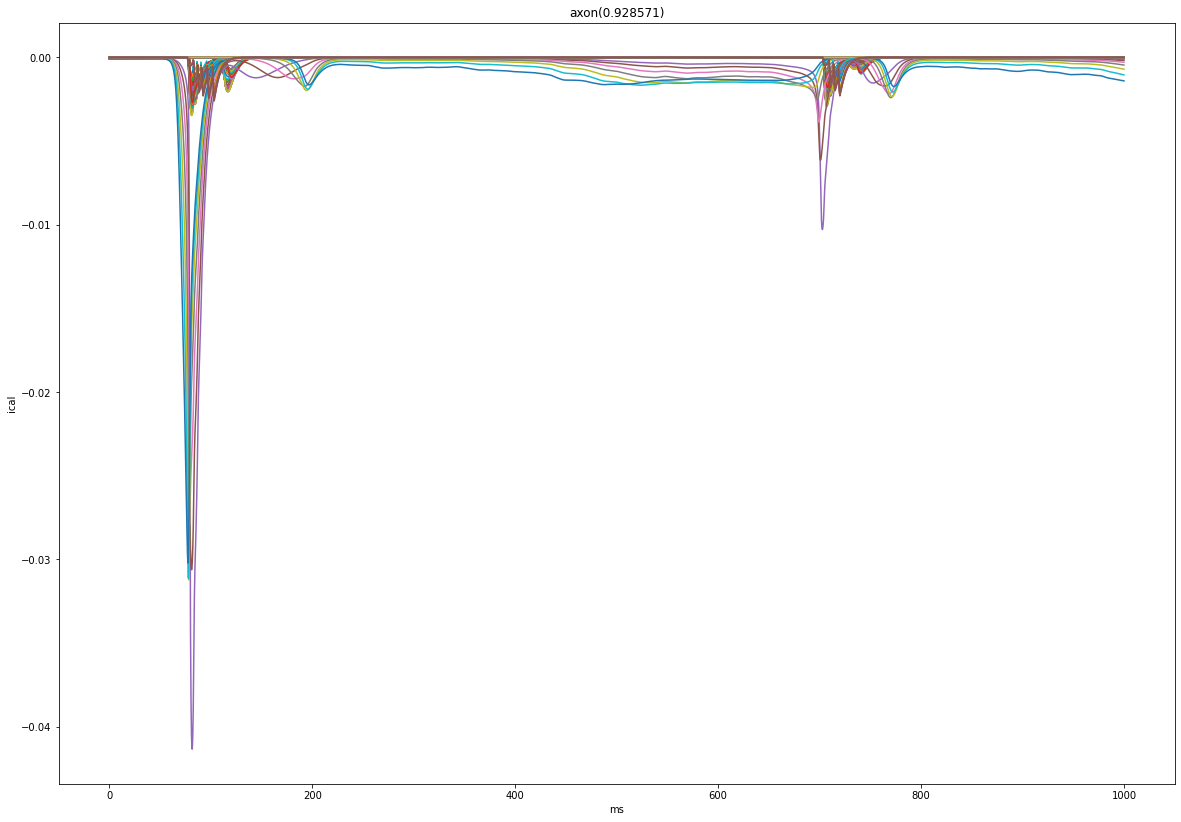

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline



# Ca LVA current 

plt.figure(figsize=(20,14))
for i in range(ical_data.shape[0]):
    plt.plot(t,ical_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('ical')
    plt.xlabel('ms')
plt.show()

In [38]:
sec14 = []
for i in range(nseg-1):
  if AllSegSection[i] == 12:
    sec14.append(i)

len(sec14)

17

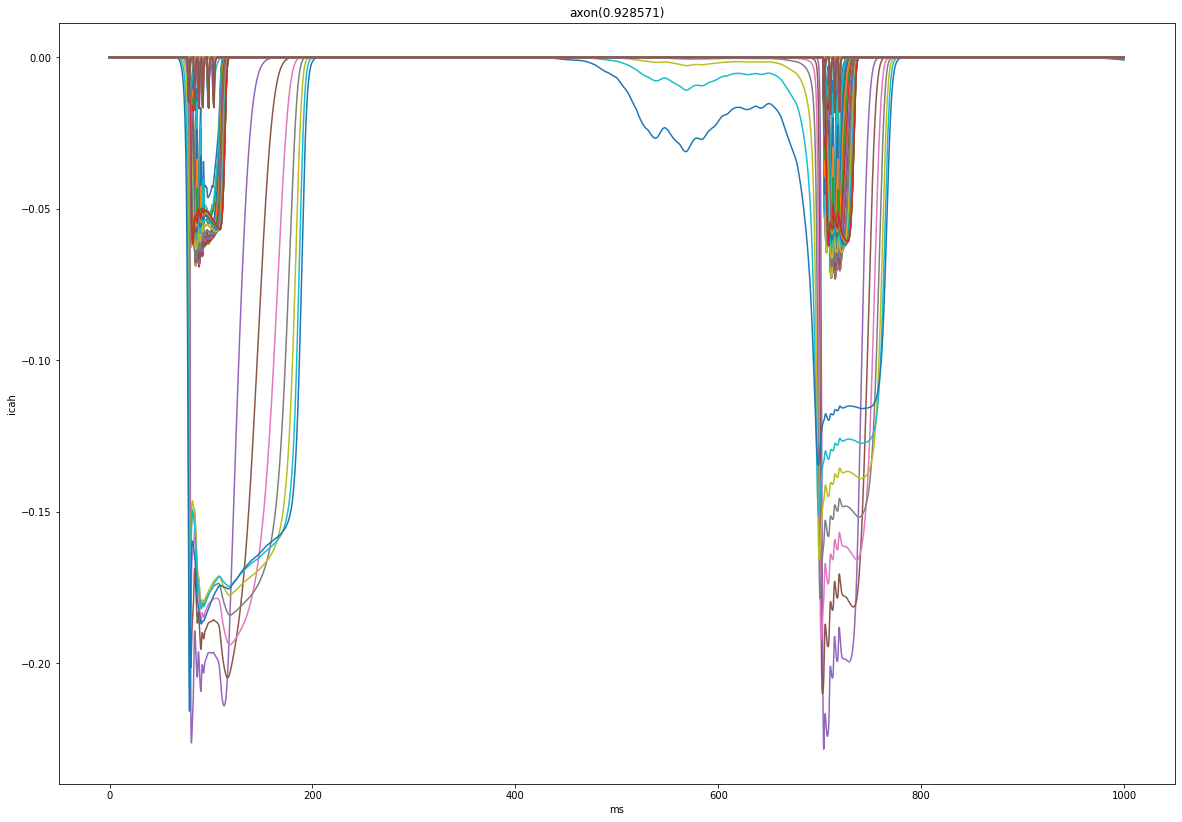

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline


# CA HVA current

plt.figure(figsize=(20,14))
for i in range(icah_data.shape[0]):
    plt.plot(t,icah_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('icah')
    plt.xlabel('ms')
plt.show()

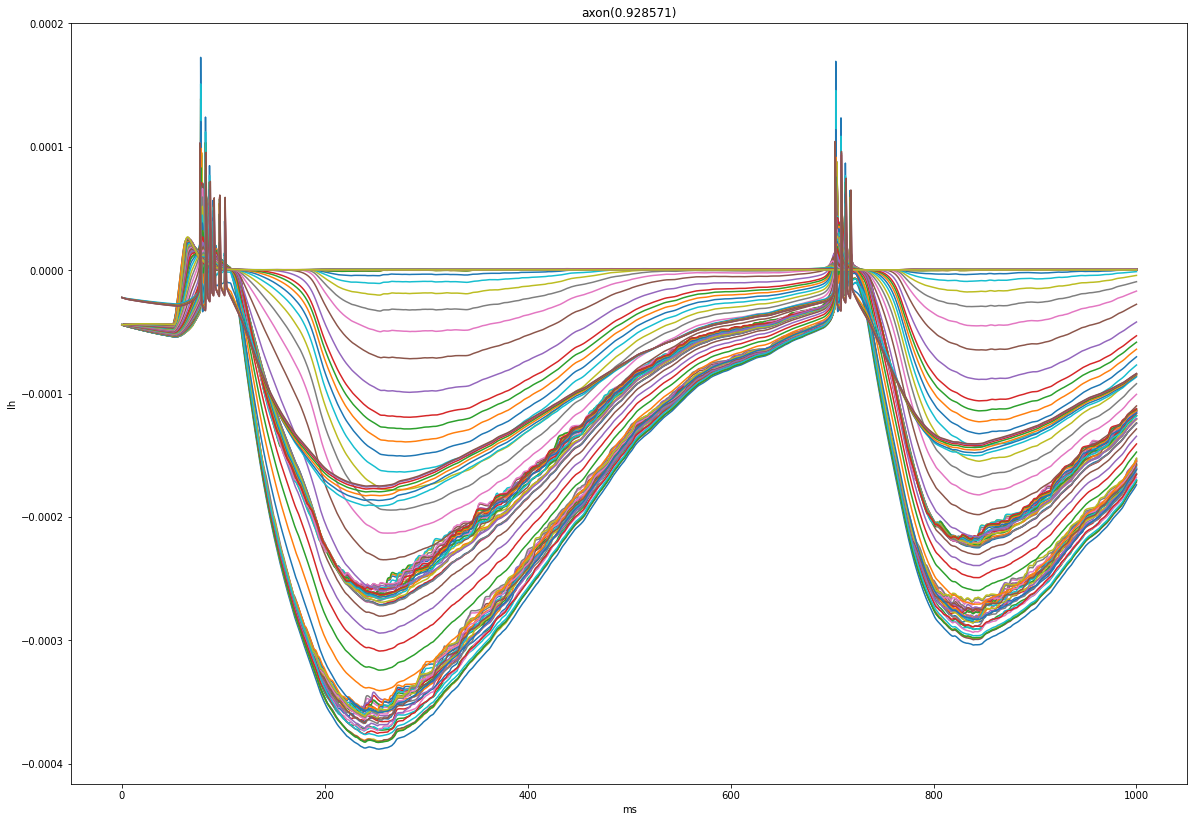

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


# h current

plt.figure(figsize=(20,14))
for i in range(ih_data.shape[0]):
    plt.plot(t,ih_data[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('Ih')
    plt.xlabel('ms')
plt.show()

82


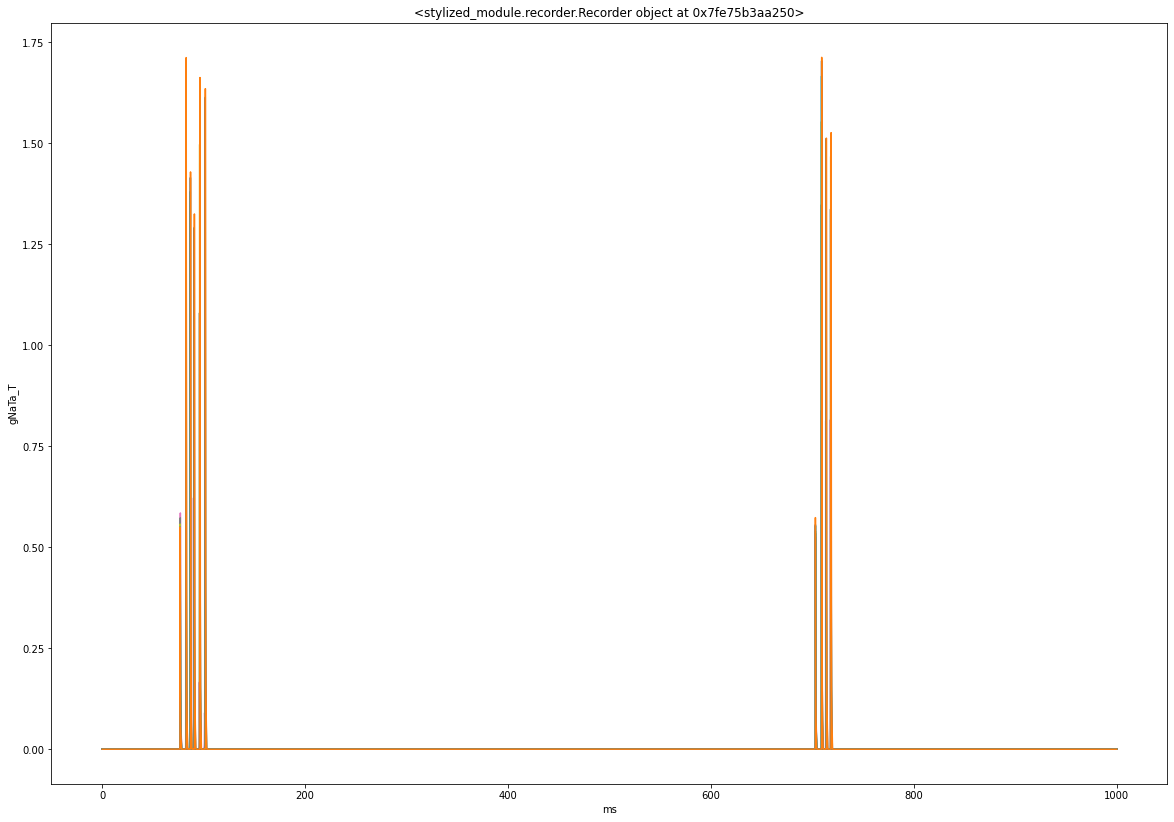

In [41]:
sec = []
for i in range(nseg-1):
  if AllSegSection[i] >= 11 :
    sec.append(i)

print(len(sec))



plt.figure(figsize=(20,14))
for i in sec:
    plt.plot(t,gNaTa_T_data[i,:])
    plt.title(gNaTa_T, loc='center')
    plt.ylabel('gNaTa_T')
    plt.xlabel('ms')
plt.show()

# plt.figure(figsize=(20,14))
# for i in sec14:
#     plt.plot(t,gNaTa_T_data[i,:])
#     plt.title(gNaTa_T, loc='center')
#     plt.ylabel('gNaTa_T')
#     plt.xlabel('ms')
# plt.show()

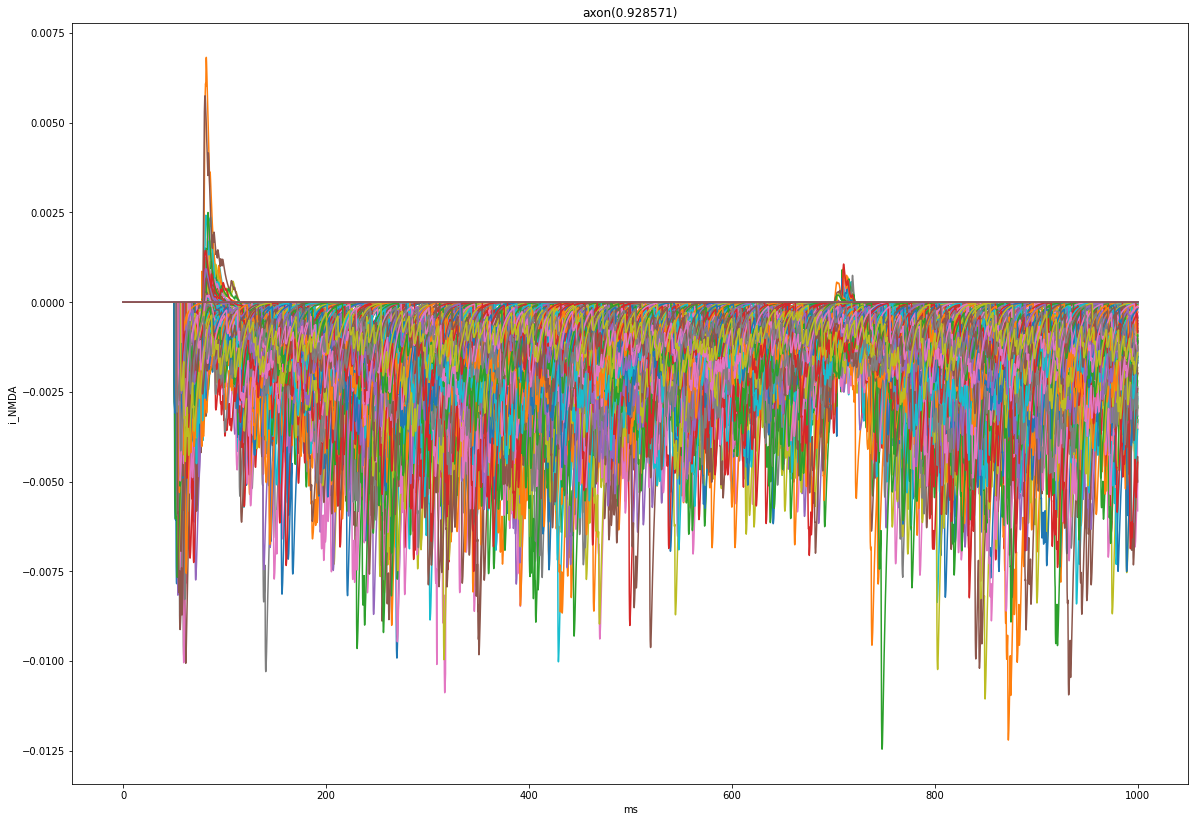

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline


#NMDA current 

plt.figure(figsize=(20,14))
for i in range(len(i_NMDA_bySeg)):
    plt.plot(t,i_NMDA_bySeg[i])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('i_NMDA')
    plt.xlabel('ms')
plt.show()

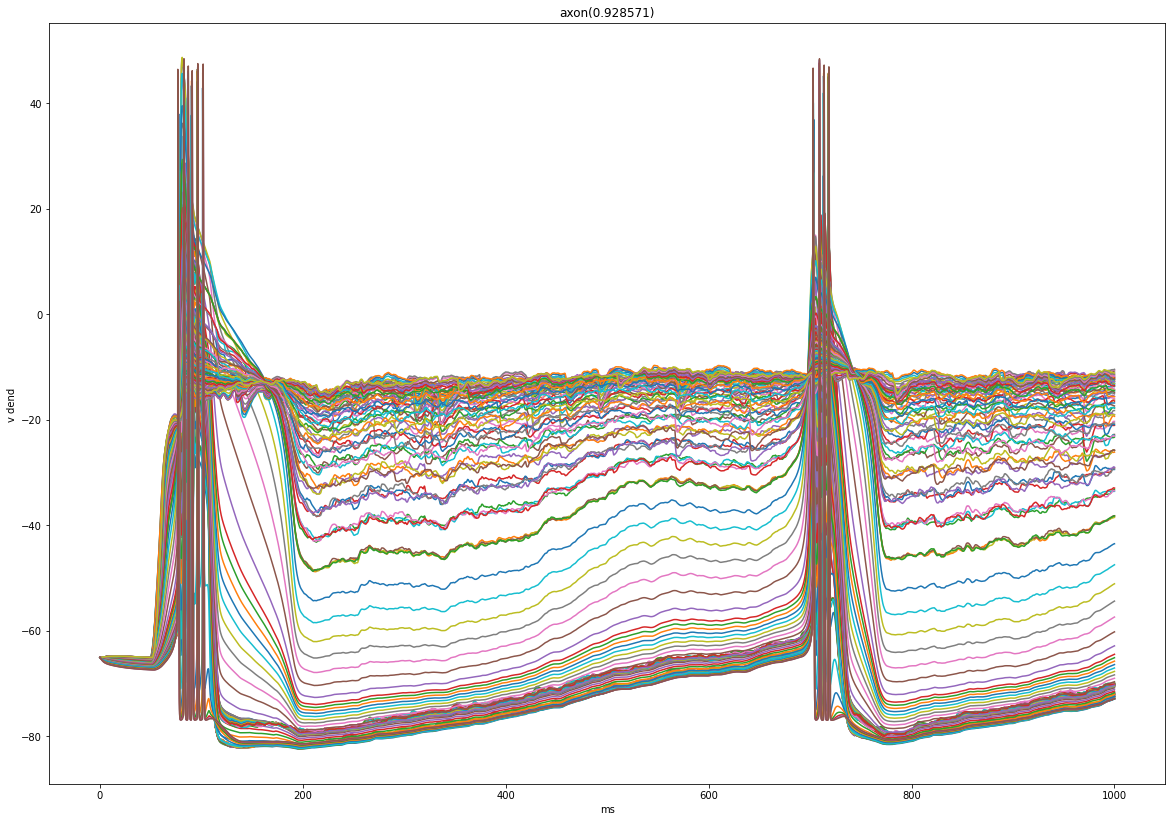

In [43]:



#NMDA current 

plt.figure(figsize=(20,14))
for i in range(len(v_dend)):
    plt.plot(t,v_dend[i])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('v dend ')
    plt.xlabel('ms')
plt.show()